In [1]:
# Import Libraries 
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import missingno as msno
import urllib.request
import requests
import urllib3
import folium
import re
import os
from matplotlib import font_manager as fm
from matplotlib import rc
import warnings
warnings.filterwarnings(action = 'ignore')
plt.style.use('ggplot')
plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터셋 설명
- 장애인 전용 체육시설현황
    - 출처: 생활체육정보센터
- 종목별장애인스포츠활성정보 (2020년 10월기준) 
    - 출처: Copyright kspo
- 장애인 스포츠강좌_자체크롤링 (2020년 12월초기준)
    - 출처: 국민체육진흥공단 홈페이지 (바우처)
- 장애인 스포츠강좌이용권 시설정보
    - 출처:Copyright kspo

In [2]:
# Import Dataset
prefer=pd.read_csv('data/종목별장애인스포츠활성정보.csv',encoding='cp949')
crawl=pd.read_csv('data/장애인스포츠강좌_자체 크롤링.csv',encoding='cp949')
disable=pd.read_csv('data/장애인전용체육시설현황.csv',encoding='cp949')
facility=pd.read_csv('data/장애인스포츠강좌이용권시설정보.csv',encoding='cp949')
extra_facilities=pd.read_csv('data/장애인스포츠강좌이용권시설인근편의시설정보.csv',encoding='cp949')

In [69]:
crawl

,시설명,대표자,연락처,시도,시군구,지도자,시설면적,운동종류,장애종류,강의명,...,요일,강사명,기간,차량지원,장애 지원시설,수강료,경도,위도,실금액,실금액2
0,(사)신나는사상스포츠클럽,유재우,02-319-7330,부산광역시,사상구,1명,1 ㎡,배드민턴,"지체, 시각, 청각/언어, 지적/자폐, 뇌병변, 기타",[12월] 생활체육,...,"화,목",소대승,2020.12.01 ~ 2020.12.10,미지원,"장애인 화장실,장애인용 엘리베이터,장애인전용 주차구역",80000,128.994875,35.147446,무료강좌,2만원이하
1,(주)꿈자라다,김병식,031-719-1441,경기도,성남시,11명,409 ㎡,기타종목,"지적/자폐, 기타",[12월] 특수체육,...,"월,화,수,목,금,토",류정국,2020.12.01 ~ 2020.12.10,미지원,"장애인 화장실,장애인용 엘리베이터,장애인전용 주차구역,주출입구 단차없음",80000,127.122609,37.408783,무료강좌,2만원이하
2,(주)디에스그룹 달서복싱체육관 대곡점,정희준,02-244-7362,대구광역시,달성군,3명,3362 ㎡,복싱,"지체, 시각, 청각/언어, 지적/자폐, 기타",[12월] 신나는 운동 복싱교실 헬스,...,"월,화,수,목,금","정희준,,손예지",2020.12.01 ~ 2020.12.10,미지원,"장애인전용 주차구역,주출입구 단차없음,시각장애인 편의서비스,청각장애인 편의서비스",80000,128.511288,35.809193,무료강좌,2만원이하
3,(주)스타칼리휘트니스,현보미,02-3141-4477,서울특별시,서대문구,2명,1705 ㎡,헬스,기타,[12월] 헬스,...,"월,화,수,목,금,토,일",이원준,2020.12.01 ~ 2020.12.10,미지원,NaN,80000,126.930272,37.565213,무료강좌,2만원이하
4,(주)애플스포츠,최장용,043-854-1919,충청북도,충주시,2명,360 ㎡,롤러인라인,"청각/언어, 지적/자폐",[12월] 즐거운 인라인교실,...,"월,화,수,목,금,토",애플쌤,2020.12.01 ~ 2020.12.10,지원,NaN,80000,127.920623,36.973603,무료강좌,2만원이하
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,흑추관합기도 사천도장,김영재,043-212-0122,충청북도,청주시,2명,196 ㎡,합기도,기타,[12월] 합기도,...,"월,수,금",김영재,2020.12.01 ~ 2020.12.10,지원,"장애인용 엘리베이터,장애인전용 주차구역",80000,127.481396,36.668617,무료강좌,2만원이하
1104,희망찬코리아,정은철,063-226-8828,전라북도,전주시,명,㎡,수영,"지체, 청각/언어, 지적/자폐, 뇌병변, 기타",[12월] 재활수영,...,"월,화,수,목,금","김승두,,이민규",2020.12.01 ~ 2020.12.10,미지원,NaN,80000,127.112653,35.795412,무료강좌,2만원이하
1105,희망체육관,김성식,031-0000-0000,경기도,연천군,1명,7392 ㎡,태권도,지적/자폐,[12월] 태권도,...,"월,화,수,목,금",김성식,2020.12.01 ~ 2020.12.10,미지원,"장애인전용 주차구역,휠체어 대여",80000,127.068857,38.027848,무료강좌,2만원이하
1106,힐링휘트니스,김준성,063-242-9688,전라북도,전주시,1명,177 ㎡,헬스,"청각/언어, 기타",[12월] 줌바 피트니스 댄스,...,"월,화,목,금",김홍자,2020.12.01 ~ 2020.12.10,미지원,NaN,80000,127.170829,35.826830,무료강좌,2만원이하


## 자주 사용되는 함수생성

In [3]:
# 함수생성 
def 시설현황시각화(data,column,title):
    plt.figure(figsize = (16, 5))
    plot_data = pd.DataFrame(data[column].value_counts()).sort_values(by=column,ascending=False)

    sns.barplot(x = plot_data.index, y = column, data = plot_data)
    plt.ylabel('')
    plt.title(title,fontsize=13)

    for index, [value] in enumerate(plot_data.values):
        plt.text(index, value, value, ha = 'center', fontsize = 13)

In [4]:
def 결측치(data):
    %matplotlib inline
    msno.matrix(data,figsize=(10,3))

## 장애인전용체육시설현황 EDA
- 전국의 장애인전용 체육시설은 68곳이 존재하며 민간시설에 비해 많이 부족함.
- 시/도에 따른 장애인 전용 체육시설은 경기, 대전, 서울순으로 면적, 인구밀도에 비례하지 않는다.

In [5]:
print('전국의 장애인전용 체육시설: '+str(disable.shape[0]))

전국의 장애인전용 체육시설: 68


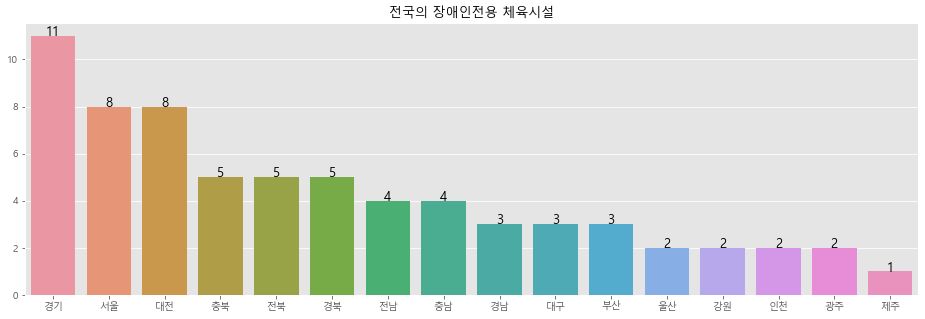

In [6]:
시설현황시각화(disable,'시/도','전국의 장애인전용 체육시설')

## 스포츠강좌이용권 시설정보 EDA
- 시설정보데이터에 대표자 전화번호, 시설상세주소가 없는 경우가 존재하긴 큰 문제가 되지않으므로 결측치처리를 하지않음.  
- 전국별 장애인 스포츠강좌이용권을 제공하는 시설수는 경기가 가장 많았으며 그 다음 서울, 대구, 부산순이다.
- 즉, 경기에서 가장 장애인관련사업에 관심이 있다고 할 수 있음.  

In [7]:
facility.isnull().sum()

시도코드        0
시도명         0
시군구코드       0
시군구명        0
시설명         0
대표자전화번호    32
우편번호        0
시설주소        0
시설상세주소     10
주요종목코드      0
주요종목명       0
시설좌표경도      0
시설좌표위도      0
강좌구분        0
dtype: int64

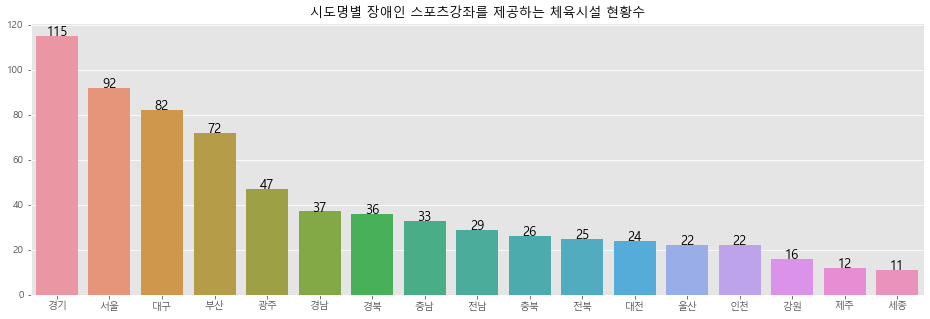

In [8]:
시설현황시각화(facility,'시도명','시도명별 장애인 스포츠강좌를 제공하는 체육시설 현황수')

## 종목별장애인스포츠활성정보 EDA

In [9]:
# 파생변수 생성
prefer['운동경험자선호비율']=(prefer['운동경험자시간여유선호비율']+prefer['운동경험자금전여유선호비율'])/2

In [10]:
# EDA를 위한 파이차트 함수 

def 파이차트시각화(labels,frequency,title):
    fig, ax= plt.subplots(figsize=(13,8))
    fig.suptitle(title,fontsize=25)
    pie = ax.pie(frequency, # 파이차트 출력
        startangle=90, # 시작점을 지정 (degree=90도) 
        counterclock=False, # 시계방향으로 그려짐 (defalut=True)   
        )
    total = np.sum(frequency)

    threshold = 5
    sum_pct = 0 # 퍼센티지
    count_less_5pct = 0 # 5%보다 작은 라벨의 개수
    spacing = 0.1
    for i,l in enumerate(labels):
        ang1, ang2 = ax.patches[i].theta1, ax.patches[i].theta2 # 파이의 시작 각도와 끝 각도
        center, r = ax.patches[i].center, ax.patches[i].r # 파이의 중심 좌표
        
        ## 비율 상한선보다 작은 것들은 계단형태로 만든다.
        if frequency[i]/total*100 < threshold:
            x = (r/2+spacing*count_less_5pct)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] # 텍스트 x좌표
            y = (r/2+spacing*count_less_5pct)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] # 텍스트 y좌표
            count_less_5pct += 1
        else:
            x = (r/2)*np.cos(np.pi/180*((ang1+ang2)/2)) + center[0] # 텍스트 x좌표
            y = (r/2)*np.sin(np.pi/180*((ang1+ang2)/2)) + center[1] # 텍스트 y좌표
        
        ##퍼센티지 출력
        if i < len(labels) - 1:
            sum_pct += float(f'{frequency[i]/total*100:.2f}')
            ax.text(x,y,f'{frequency[i]/total*100:.2f}%',ha='center',va='center',fontsize=12)
        else: # 마지막 파이 조각은 퍼센티지의 합이 100이 되도록 비율을 조절
            ax.text(x,y,f'{100-sum_pct:.2f}%',ha='center',va='center',fontsize=12)
    
    plt.legend(pie[0],labels,loc=4) # 범례 (loc=1: 오른쪽상단, loc=2: 왼쪽상단, loc=3: 왼쪽상단, loc=4: 오른쪽상단)
    plt.show()



## 대분류명별 스포츠 강좌 수 
-  대부분 강좌는 체력단련 및 생활운동 -> 무도/격투기 -> 구기 및 라켓류 순으로 이루어져있다. 


In [11]:
group=prefer.groupby(['수요운동종목대분류명']).sum()
group1=group[group['강좌종목수']!=0]
group2=group1['강좌종목수'].sort_values(ascending=False).reset_index()

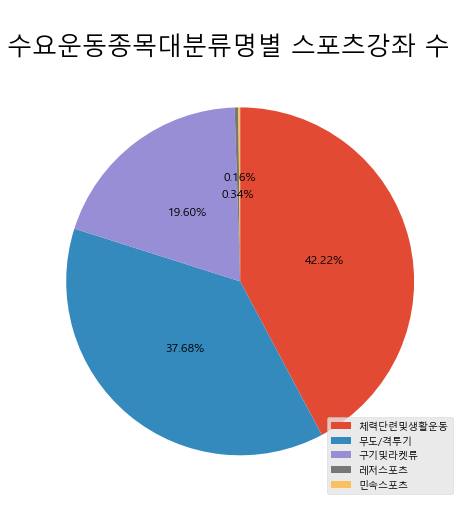

In [12]:
labels=group2['수요운동종목대분류명']
frequency=list(group2['강좌종목수'])
title='\n수요운동종목대분류명별 스포츠강좌 수'
파이차트시각화(labels,frequency,title)

##  소분류명별 스포츠 강좌 수 
- 소분류명별 스포츠강좌는 태권도(28%), 기타체력단련(19%), 수영(17.5%), 무도/격투기(11%), 탁구(6%) 순으로 강좌가 구성되어있음. 

In [13]:
course=prefer.sort_values(by='강좌종목비율',ascending=False).head(10)

In [14]:
course.head(3)

,수요운동종목대분류명,수요운동종목소분류명,운동경험자주요수요비율,운동경험자시간여유선호비율,운동경험자금전여유선호비율,비운동경험자종목선호비율,수요운동종목지수값,수요운동종목지수순위,강좌종목명,강좌종목수,강좌종목비율,운동경험자선호비율
2,무도/격투기,태권도,0.2,0.4,0.3,0.3,0.300,23,태권도,308,21.34442,0.35
40,체력단련및생활운동,체력단련및생활운동_그외종목,4.1,3.0,3.6,2.4,3.298,6,체력단련및생활운동_그외종목,210,14.55301,3.30
33,체력단련및생활운동,수영,7.2,17.0,17.1,8.4,12.532,3,수영,189,13.09771,17.05


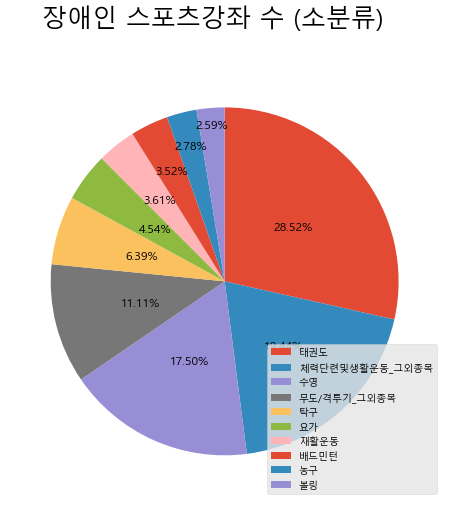

In [15]:
labels=course['수요운동종목소분류명']
frequency=list(course['강좌종목비율'])
title='장애인 스포츠강좌 수 (소분류)'
파이차트시각화(labels,frequency,title)

## 장애인 운동경험자 비경험자들 선호비율 EDA
- 운동비경험자경우 체력단련 및 생활운동 선호비율이 월등히 높은것으로 보아 장애인에 경우 새로운 운동에 대한 어려움이 보여짐.
- 운동경험자 경우 체력단련 및 생활운동의 선호율이 10% 줄어들고 기타스포츠 및 구기 및 라켓류의 선호비율이 높아졌는것을 통하여  
운동을 경험한 후 선호비율이 더 다양해졌다는 것을 알 수 있음.

In [16]:
group2=group[group['비운동경험자종목선호비율']!=0].reset_index()
labels=list(group2['수요운동종목대분류명'])
frequency=list(group2['비운동경험자종목선호비율'])
title='\n장애인 비운동경험자 선호비율'

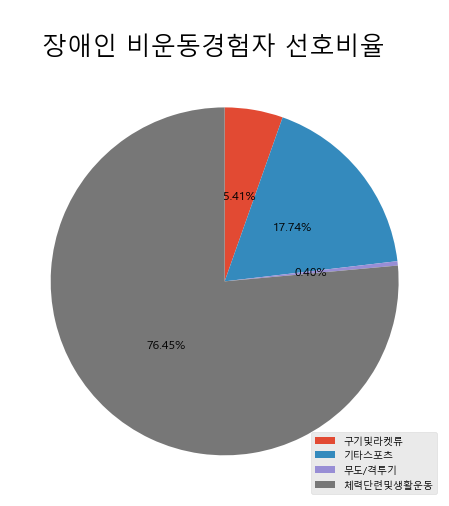

In [17]:
파이차트시각화(labels,frequency,title)

In [18]:
group2=group.sort_values('운동경험자선호비율',ascending=False).reset_index()
labels=list(group2['수요운동종목대분류명'])
frequency=list(group2['운동경험자선호비율'])
title='\n장애인 운동경험자 선호비율'

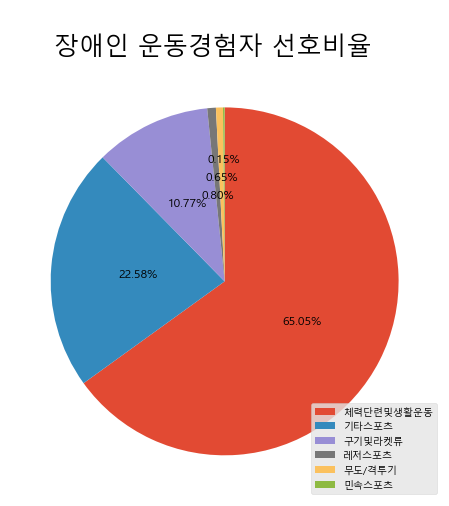

In [19]:
파이차트시각화(labels,frequency,title)

## 운동경험자 비운동경험자의 선호차이 파악
- 운동경험 후 선호비율 차이를 파생변수로 생성하여 높은 종목들을 파악
- 수영, 기타스포츠_그외종목, 요가, 자전거,사이클 그리고 웨이트트레이닝 순으로 운동경험 후 선호도가 높았다. 

In [20]:
# 운동경험자 선호 비율 파생변수 
prefer['운동경험자선호비율']=(prefer['운동경험자금전여유선호비율']+prefer['운동경험자시간여유선호비율'])/2
# 운동경험자와 비운동경험자의 선호차이
prefer['운동전후선호비율차이']=(prefer['운동경험자선호비율']-prefer['비운동경험자종목선호비율']).round(2)

In [21]:
prefer.loc[:,['수요운동종목소분류명','운동전후선호비율차이']].sort_values('운동전후선호비율차이',ascending=False).head(5)

,수요운동종목소분류명,운동전후선호비율차이
33,수영,8.65
4,기타스포츠_그외종목,3.85
38,요가,2.55
41,"자전거,사이클",1.90
39,보디빌딩(웨이트트레이닝),1.40


# 12.01 ~ 12.10 기준 강좌 (크롤링) EDA

## 강좌수 EDA
- 10월 기준 강좌수:  태권도(28%), 기타체력단련(19%), 수영(17.5%), 무도/격투기(11%), 탁구(6%)
- 12월 기준 강좌수:  기타종목(27%), 태권도(23%), 수영(18%), 헬스(12%), 탁구(4%)
- 10월과 12월에 상위 강좌 종목수의 변화가 있었지만 큰 차이는 없음. 
- 첫번째로 선호비율이 증가했던 기타스포츠_그외종목 카테고리에는 *특수체육*, 뉴스포츠, 4구등의 수업이 존재함 
    - *특수체육* 에서 '특수'는 장애인 또는 특숙육대상자를 의미한다. (출처) https://m.blog.naver.com/wsrthfk1/222013114868

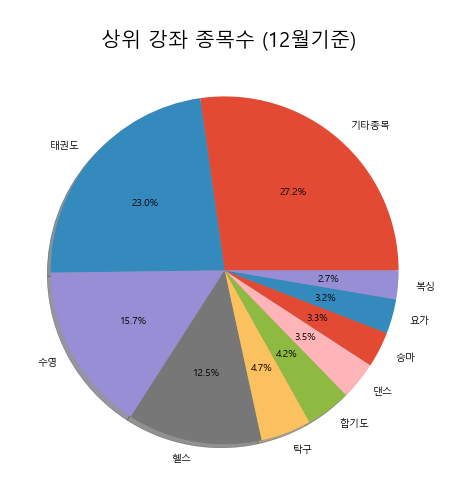

In [22]:
# 강좌 종류 상위 10개 시각화 
운동종목수=crawl['운동종류'].value_counts().head(10)
plt.figure(figsize = (8, 8))
plt.pie(x=운동종목수,labels=운동종목수.index,autopct='%.1f%%',shadow=True)
plt.title('\n 상위 강좌 종목수 (12월기준)',fontsize=20)
plt.show()

In [23]:
crawl[crawl['운동종류']=='기타종목'].loc[:,['운동종류','강의명']].value_counts().head(5)

운동종류  강의명              
기타종목  [12월] 특수체육           43
      [12월] 뉴스포츠            9
      [12월] 그룹강좌            3
      [12월] 4구당구 입문(초보)     3
      [12월] 보치아교실           3
dtype: int64

In [24]:
# 컬럼자료형 확인
crawl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1108 entries, 0 to 1107
Data columns (total 19 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   시설명      1108 non-null   object 
 1   대표자      1102 non-null   object 
 2   연락처      1108 non-null   object 
 3   시도       1108 non-null   object 
 4   시군구      1108 non-null   object 
 5   지도자      1108 non-null   object 
 6   시설면적     1108 non-null   object 
 7   운동종류     1108 non-null   object 
 8   장애종류     1108 non-null   object 
 9   강의명      1108 non-null   object 
 10  시간       1108 non-null   object 
 11  요일       1108 non-null   object 
 12  강사명      1098 non-null   object 
 13  기간       1108 non-null   object 
 14  차량지원     1108 non-null   object 
 15  장애 지원시설  666 non-null    object 
 16  수강료      1108 non-null   object 
 17  경도       1108 non-null   float64
 18  위도       1108 non-null   float64
dtypes: float64(2), object(17)
memory usage: 164.6+ KB


In [25]:
# 수강료 컬럼 자료형 변경 (범주형에서 숫자형)
for index in range(crawl.shape[0]):
    crawl['수강료']=crawl.수강료.str.replace(',','')
crawl['수강료']=crawl['수강료'].astype('int')


In [26]:
# 수강료 범주형에서 숫자형변수로 변환
# 실제부담금액 파생변수만들기 
crawl['실금액']=crawl['수강료']-80000
crawl['실금액2']=crawl['수강료']-80000

In [27]:
# 데이터값 구간화 
def 실금액(x):
    if x== 0 : return '무료강좌'
    elif x<50000 : return '5만원이하'
    elif x<100000 : return '10만원이하'
    else: return '10만원이상'


In [28]:
# 데이터값 구간화2
def 실금액2(x):
    if x<20000 : return '2만원이하'
    elif x<50000 : return '5만원이하'
    elif x<100000 : return '10만원이하'
    else: return '10만원이상'

In [29]:
crawl['실금액'] = crawl['실금액'].apply(실금액)
crawl['실금액2'] = crawl['실금액2'].apply(실금액2)

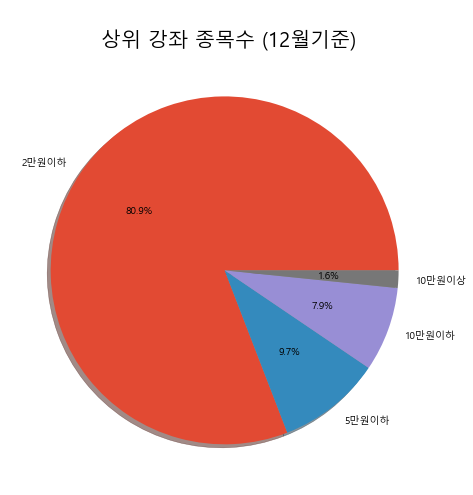

In [30]:
#  구간화2 적용후 시각화
실금액=crawl['실금액2'].value_counts().head(10)
plt.figure(figsize = (8, 8))
plt.pie(x=실금액,labels=실금액.index,autopct='%.1f%%',shadow=True)
plt.title('\n 상위 강좌 종목수 (12월기준)',fontsize=20)
plt.show()

## 무료 스포츠강좌
- 스포츠강좌이용권 연간 지원금이 8만원 지원되므로 강좌금액 - 8만원 = 0원인 경우 무료강좌로 간주함
- 기타종목(특수체육), 태권도, 헬스, 수영, 탁구 순으로 무료강좌비율이 구성되어있음.


In [31]:
크롤링_무료강좌=crawl[crawl['실금액']=='무료강좌']

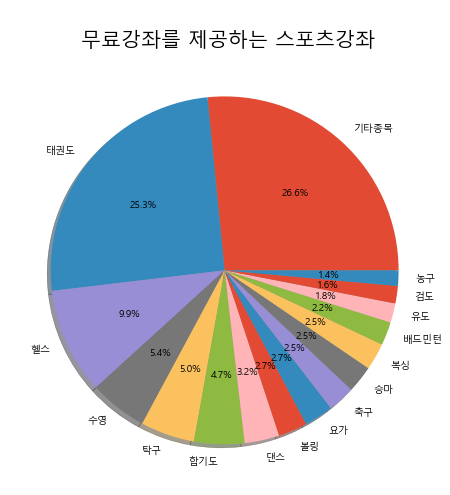

In [32]:
운동종목수=크롤링_무료강좌['운동종류'].value_counts().head(16)
plt.figure(figsize = (8, 8))
plt.pie(x=운동종목수,labels=운동종목수.index,autopct='%.1f%%',shadow=True)
plt.title('\n 무료강좌를 제공하는 스포츠강좌',fontsize=20)
plt.show()

## 장애인스포츠강좌이용권시설인근편의시설정보 EDA

In [33]:
print('인근편의시설데이터: ' ,extra_facilities.shape)
extra_facilities.head(2)

인근편의시설데이터:  (391035, 22)


,체육시설시도코드,체육시설시도명,체육시설시군구코드,체육시설시군구명,체육시설명,체육시설대표자전화번호,체육시설우편번호,체육시설주소,체육시설상세주소,체육시설주요종목코드,...,체육시설위도,편의시설ID,편의시설설립일자,편의시설명,편의시설경도,편의시설위도,편의시설유형코드,편의시설유형명,편의시설주소,체육편의시설거리
0,11,서울,11410,서대문구,매직짐,23798815.0,3628,서울특별시 서대문구 통일로 484,유진상가2층 매직짐(홍제동),25,...,37.591589,681,19920220.0,천연동주민센터,126.959068,37.571113,UC0A03,지역자치센터,서울특별시 서대문구 성산로 64,2.682
1,11,서울,11500,강서구,박사 경희대 태권도,220655599.0,7722,서울특별시 강서구 까치산로10길 73,2층(화곡동),22,...,37.540887,18726,20100106.0,현대홈타운,126.834523,37.528751,UC0U04,다세대주택,서울특별시 양천구 남부순환로63길 12,1.790


### 결측치 확인
- 체육시설대표자전화번호와 편의시설설립일자는 중요변수가 아니라는 가정에 결측치제거를 하지않음.

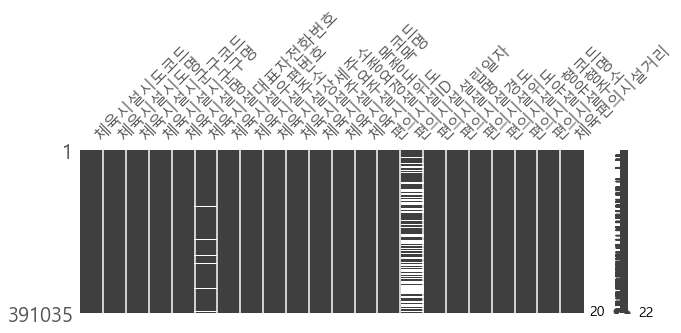

In [34]:

결측치(extra_facilities)

In [35]:
extra_facilities.columns

Index(['체육시설시도코드', '체육시설시도명', '체육시설시군구코드', '체육시설시군구명', '체육시설명', '체육시설대표자전화번호',
       '체육시설우편번호', '체육시설주소', '체육시설상세주소', '체육시설주요종목코드', '체육시설주요종목명', '체육시설경도',
       '체육시설위도', '편의시설ID', '편의시설설립일자', '편의시설명', '편의시설경도', '편의시설위도', '편의시설유형코드',
       '편의시설유형명', '편의시설주소', '체육편의시설거리'],
      dtype='object')

## 편의시설유형명 EDA
- 편의시설데이터셋에 관련없는 시설 그리고 체육시설부터 너무 멀어 접근성, 효율성이 떨어지는 시설들이 다수 존재함.

In [36]:
print(extra_facilities['편의시설유형명'].unique())
print(extra_facilities[extra_facilities['체육편의시설거리']>2].loc[:,['체육편의시설거리']]['체육편의시설거리'].unique())

['지역자치센터' '다세대주택' '아파트' '금융업소 등 일반업무시설' '수퍼마켓·일용품 등의 소매점' '일반숙박시설(호텔, 여관)'
 '교육원·직업훈련소·학원 등' '의원·치과의원·한의원·조산소(산후조리원)' '우체국' '어린이집'
 '병원·치과병원·한방병원·정신병원·요양병원' '일반음식점' '고등학교' '중학교' '유치원' '노인복지시설(경로당포함)'
 '초등학교' '종교집회장' '이용원·미용원·목욕장' '종합병원' '아파트 부대복리시설' '집회장' '운동장' '파출소, 지구대'
 '국가 또는 지자체 청사' '도매·소매시장·상점' '아동복지시설' '공장' '공중화장실' '방송국' '공연장' '주차장'
 '이외 사회복지시설' '관광숙박시설(관광호텔, 콘도등)' '장애인복지시설' '국민건강보험공단 및 지사' '전문대학'
 '생활권수련시설' '연립주택' '대학교' '전시장' '자연공원' '특수학교' '기숙사' '휴게음식점·제과점' '대피소' '체육관'
 '전신전화국' '도서관' '도시공원' '공공도서관' '지역아동센터' '보건소' '장례식장(의료시설의 부수시설제외)'
 '근로복지공단 및 지사' '국민연금공단 및 지사' '야외음악당·야외극장·어린이회관' '관람장' '동·식물원' '자연권수련시설'
 '한국장애인고용공단 및 지사' '안마시술소' '운전학원' '휴게소' '격리병원' '교도소·구치소' '화장시설'
 '봉안당(종교시설에 해당하는 것은 제외)']
[2.682 2.001 2.002 2.026 2.028 2.033 2.034 2.035 2.036 2.04  2.041 2.042
 2.046 2.047 2.07  2.071 2.072 2.076 2.077 2.078 2.079 2.081 2.083 2.084
 2.086 2.087 2.089 2.092 2.094 2.1   2.129 2.132 2.135 2.138 2.141 2.142
 2.144 2.147 2.149 2.15  2.153 2.158 2.159 2.197 2.198 2.2   2.201 2.202

## 장애인 편의시설 설명
- 사회복지시설: 사회복지사업을 실시할 목적으로 설치된 시설로 보호대상은 아동, 장애인, 노인, 부랑인, 정신질환자 등 사회적양자
    - 출처: https://m.blog.naver.com/PostView.nhn?blogId=a2496224&logNo=80042824808&proxyReferer=https:%2F%2Fwww.google.com%2F
    
- 지방자치센터: 장애인복지법에 의해 지방자치단체등은 책무를 명백히하고 장애인의 의료, 훈련, 보호,교육, 고용의 증진, 수당의 지급을 추진 
    - 출처: https://www.law.go.kr/LSW/lsInfoP.do?lsiSeq=914#0000
    

In [65]:
# 장애인에게 실질적으로 도움이 될만한 시설들을 리스트 
listfordisable=['지역자치센터','종합병원','이외 사회복지시설','장애인복지시설','보건소','한국장애인고용공단 및 지사']

In [66]:
# 필요시설들이 포함된 데이터만 추출 
extra_facilities2=extra_facilities[extra_facilities['편의시설유형명'].isin(listfordisable)].loc[:,['체육시설시도명','체육시설명','체육시설주요종목명','체육시설경도','체육시설위도','편의시설명','편의시설유형명','편의시설경도','편의시설위도','체육편의시설거리']]

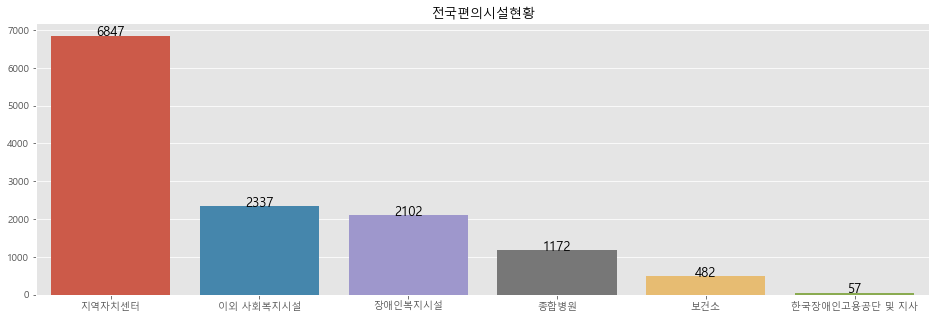

In [76]:
시설현황시각화(extra_facilities2,'편의시설유형명',"전국편의시설현황")


In [39]:
# 시군구 리스트화
list=extra_facilities2['체육시설시도명'].unique().tolist()

In [50]:
# 각 지역별 데이터셋과 지도생성 (필요시 사용)
for i in range(len(list)):
    globals()['지역_{}'.format(i)]=extra_facilities2[(extra_facilities2['체육시설시도명']==list[i])&(extra_facilities2['체육편의시설거리']<0.5)]
    center = [36.8658926,127.2101321]
    globals()['map_{}'.format(i)]=folium.Map(location=center,zoom_start=7)

## 바우처 체육시설및 편의시설 지도시각화 EDA
### 설명
    - 바우처를 제공하는 체육시설 : 회색원
    - 편의시설: 파랑색 Marker로 표시
    - ZOOM(스크롤이용)을 하여 파악가능
### 시각화
    - 시별로 확대하면 구분가능
    - 주변 편의시설이 체육시설이 다수 존재

In [193]:
map=folium.Map(location=center,zoom_start=7)
drop_du=extra_facilities2.drop_duplicates(subset=['체육시설경도','체육시설위도'],keep='last')
for i in range(len(drop_du)):
    folium.CircleMarker(
        location=[drop_du.iloc[i][4],drop_du.iloc[i][3]],
        color='#ffffgg',
        fill_color='#ffffgg',
        radius=100
    ).add_to(map)

In [194]:
for i in range(17):
    data=extra_facilities2[(extra_facilities2['체육시설시도명']==list[i])&(extra_facilities2['체육편의시설거리']<0.5)]
    for j in range(len(data)):
        folium.Marker(
            location=[data.iloc[j][8],data.iloc[j][7]],
            radius=10
        ).add_to(map)
       

In [196]:
# HTML로 저장 
map.save('편의시설.html')

In [201]:
from PIL import Image 
incheon=Image.open("인천_편의시설.png")

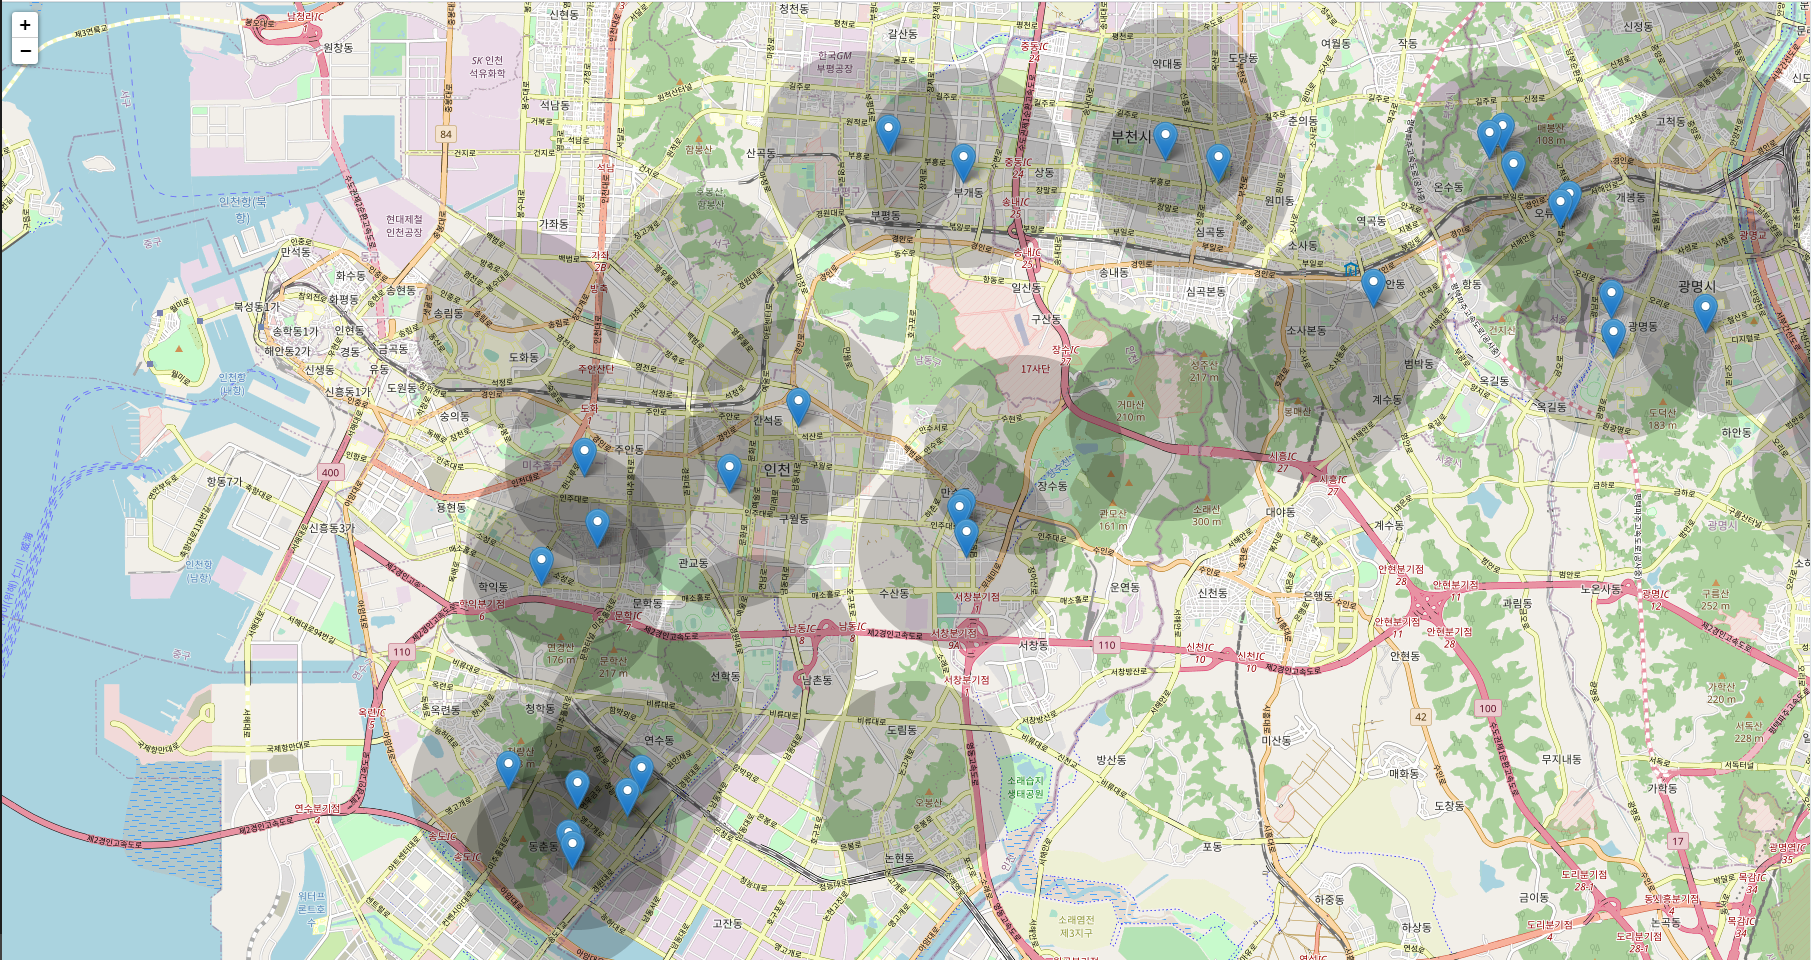

In [203]:
incheon